# Quasar Redshift Estimates with Redrock. DESI simulated Spectra

The goal of this notebook is to generate a set of quasar spectra simulations, that are then analized with redrock to obtain the 
redshift.  
We assume that desi code is installed as described in :
https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop/JuneMeeting
The only identified issue is with astropy v2, this should be downgraded to v1.3.3, after installing healpy. If installed before, healpy will upgrade again and then functions dealing with writting fits files will complain.

TODO:Check that there is a warning when calling the new_exposure funcion..

First we import the basic modules we need. 

In [2]:
import os
%pylab inline


import numpy as np
from astropy.io import fits
from astropy.table import Table
import desispec.io
import desisim.io
from desisim.obs import new_exposure
from desisim.scripts import quickgen
from desispec.scripts import group_spectra

import matplotlib.pyplot as plt



Populating the interactive namespace from numpy and matplotlib


## Environment variables and data

We will specify the enviroment variables, specially where to find the DESI spectra templates, and where do we want to save the simulated spectra. Then check enviroment variables. I assumes the desi enviroment is already set. 

In [4]:
def check_env():
    for env in ('DESIMODEL', 'DESI_ROOT', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 
            'DESI_SPECTRO_REDUX', 'SPECPROD', 'PIXPROD'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))
check_env()
%set_env SPECPROD=test_qso_only
%set_env PIXPROD=test_qso_only
rawdata_dir = desisim.io.simdir()
%set_env DESI_SPECTRO_DATA=$rawdata_dir

print('Simulated raw data will be written to {}'.format(desisim.io.simdir()))
print('Pipeline will read raw data from {}'.format(desispec.io.rawdata_root()))
print('    (without knowing that it was simulated)')
print('Pipeline will write processed data to {}'.format(desispec.io.specprod_root()))

DESIMODEL environment set to /Users/alma/Dropbox/desi/code/desimodel
DESI_ROOT environment set to /Users/alma/Dropbox/desi
DESI_SPECTRO_SIM environment set to /Users/alma/Dropbox/desi/spectro/sim
DESI_SPECTRO_DATA environment set to /Users/alma/Dropbox/desi/spectro/sim/test_qso/
DESI_SPECTRO_REDUX environment set to /Users/alma/Dropbox/desi/spectro/redux
SPECPROD environment set to test_qso
PIXPROD environment set to test_qso
env: SPECPROD=test_qso_only
env: PIXPROD=test_qso_only
env: DESI_SPECTRO_DATA=/Users/alma/Dropbox/desi/spectro/sim/test_qso_only/
Simulated raw data will be written to /Users/alma/Dropbox/desi/spectro/sim/test_qso_only/
Pipeline will read raw data from /Users/alma/Dropbox/desi/spectro/sim/test_qso_only/
    (without knowing that it was simulated)
Pipeline will write processed data to /Users/alma/Dropbox/desi/spectro/redux/test_qso_only


# Generate Noisless Spectra. 
We will use the "new_exposure" function to generate noiseless spectra, this requires the following parameters: 

In [5]:
# Here we are  genereting 1000 quasar spectra, the seed and night are set to date, so that we know when this was generated 
# and can be reproduced. 
nspec = 100
seed = 20171105
flavor = 'QSO'     ##Change to QSO, if one wants to mainly generate QSO's   
night = '20171105'
expid = 0
#It will geneterate some stars according to modelin os.getenv('DESIMODEL')+'/data/spectra/spec-sky.dat'

In [8]:
fibermap, truth = new_exposure(flavor=flavor, nspec=nspec, seed=seed, night=night, 
                               expid=expid)

INFO:io.py:625:read_basis_templates: Reading /Users/alma/Dropbox/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
INFO:io.py:625:read_basis_templates: Reading /Users/alma/Dropbox/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits


/Users/alma/miniconda3/envs/desi/lib/python3.5/site-packages/desisim-0.19.0-py3.5.egg/desisim/targets.py:426: RuntimeWarning: invalid value encountered in log10
  wise = 22.5-2.5*np.log10(meta['WISE_FLUX'].data)
/Users/alma/miniconda3/envs/desi/lib/python3.5/site-packages/desisim-0.19.0-py3.5.egg/desisim/targets.py:426: RuntimeWarning: invalid value encountered in log10
  wise = 22.5-2.5*np.log10(meta['WISE_FLUX'].data)


INFO:obs.py:226:new_exposure: skyfile /Users/alma/Dropbox/desi/code/desimodel/data/spectra/spec-sky.dat
INFO:obs.py:297:new_exposure: Wrote /Users/alma/Dropbox/desi/spectro/sim/test_qso_only/20171105/fibermap-00000000.fits
INFO:obs.py:305:new_exposure: Wrote /Users/alma/Dropbox/desi/spectro/sim/test_qso_only/20171105/simspec-00000000.fits


Now that the fiber and simspec files were generated we proceed to simulate de spectra using quickgen function.
NOTE: The quickspectra function is in github, but for some reason I can not see it from my instalation, I'll check if it is available in  NERSC. 

Reading simspec file /Users/alma/Dropbox/desi/spectro/sim/test_qso/20171105/simspec-00000000.fits.


##Uncomment this lines if you want to plot the redshift distribution generated by the new_exposure function

print('Reading fibermap file {}'.format(fiberfile))
hdu = fits.open(fiberfile)
fibermap = Table(hdu['FIBERMAP'].data)
hdu.close()
print('Reading simspec file {}.'.format(simspecfile))
hdu = fits.open(simspecfile)
meta = Table(hdu['METADATA'].data)
hdu.close()
allobjtype = meta['OBJTYPE']
redlim = (-0.2, 1.1*meta['REDSHIFT'].max())
fig, ax = plt.subplots()
for objtype in sorted(set(allobjtype)):
    indx = objtype == allobjtype
    hh = ax.hist(meta['REDSHIFT'][indx], bins=25, 
                 label=objtype, alpha=0.5, range=redlim)
    
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Simulated Spectra')
ax.legend(loc='upper right', ncol=3)
ax.margins(0.2)
ax.set_xlim(redlim)

In [11]:
#outdir_truth option seems not to work... 
fiberfile = desispec.io.findfile('fibermap', night=night, expid=expid)
simspecfile = desisim.io.findfile('simspec', night=night, expid=expid)

outfile='/Users/alma/Dropbox/desi/spectro/sim/Lya/20171106/'
args = quickgen.parse([
    '--simspec', simspecfile,
    '--fibermap', fiberfile,
    '-n 100','--outdir-truth', desisim.io.simdir(),
])
quickgen.main(args)

INFO:quickgen.py:242:main: Reading fibermap file /Users/alma/Dropbox/desi/spectro/sim/test_qso_only/20171105/fibermap-00000000.fits
INFO:quickgen.py:275:main: Initializing SpecSim with config desi
INFO:quickgen.py:281:main: Reading input file /Users/alma/Dropbox/desi/spectro/sim/test_qso_only/20171105/simspec-00000000.fits


/Users/alma/miniconda3/envs/desi/lib/python3.5/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


INFO:quickgen.py:672:main: Writing files for channel:b, spectrograph:0, spectra:0 to 100
INFO:quickgen.py:699:main: Wrote file /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/exposures/20171105/00000000/frame-b0-00000000.fits
INFO:quickgen.py:717:main: Wrote file /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/exposures/20171105/00000000/cframe-b0-00000000.fits
INFO:quickgen.py:732:main: Wrote file /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/exposures/20171105/00000000/sky-b0-00000000.fits
INFO:quickgen.py:753:main: Wrote file /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/exposures/20171105/00000000/calib-b0-00000000.fits
INFO:quickgen.py:672:main: Writing files for channel:r, spectrograph:0, spectra:0 to 100


INFO:quickgen.py:699:main: Wrote file /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/exposures/20171105/00000000/frame-r0-00000000.fits
INFO:quickgen.py:717:main: Wrote file /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/exposures/20171105/00000000/cframe-r0-00000000.fits
INFO:quickgen.py:732:main: Wrote file /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/exposures/20171105/00000000/sky-r0-00000000.fits
INFO:quickgen.py:753:main: Wrote file /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/exposures/20171105/00000000/calib-r0-00000000.fits
INFO:quickgen.py:672:main: Writing files for channel:z, spectrograph:0, spectra:0 to 100
INFO:quickgen.py:699:main: Wrote file /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/exposures/20171105/00000000/frame-z0-00000000.fits
INFO:quickgen.py:717:main: Wrote file /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/exposures/20171105/00000000/cframe-z0-00000000.fits
INFO:quickgen.py:732:main: Wrote file /Users/alma/Dropbox/d

We have genereted the simmulated spectra, before analyzing them with redrock, we group them in the brick format 

In [13]:
nside = 64
args = group_spectra.parse(['--hpxnside', '{}'.format(nside),'--nights','{}'.format(night)])
group_spectra.main(args)

INFO:group_spectra.py:74:main: Starting at Sun Nov  5 23:19:52 2017
INFO:group_spectra.py:75:main:   using raw dir /Users/alma/Dropbox/desi/spectro/sim/test_qso_only
INFO:group_spectra.py:76:main:   using spectro production dir /Users/alma/Dropbox/desi/spectro/redux/test_qso_only
INFO:group_spectra.py:197:main: Distributing 2 spectral groups among 1 processes
INFO:group_spectra.py:220:main:   (0000) Begin spectral group spectra-64-12637 at Sun Nov  5 23:19:52 2017
INFO:group_spectra.py:294:main:   (0000) End spectral group spectra-64-12637 at Sun Nov  5 23:21:51 2017
INFO:group_spectra.py:220:main:   (0000) Begin spectral group spectra-64-12639 at Sun Nov  5 23:21:51 2017
INFO:group_spectra.py:294:main:   (0000) End spectral group spectra-64-12639 at Sun Nov  5 23:22:25 2017
INFO:group_spectra.py:301:main: Finishing at Sun Nov  5 23:22:25 2017


TODO: I couldnt find the script to run redrock from the notebook, I'll to do it. In the meantime it can be run from the terminal as in this example:

rrdesi --zbest zbest-64-12637.fits --output spectra-64-12637.h5 spectra-64-12637.fits -ncpu 10

NOTE: by default uses all CPU available, so we should limit it. For larger samples it is best to make a script to run rrdesi over the different bricks. 


    

Next we analyze the redrock output by comparing the redshift histogram from the redrock output 
to that from the original fibermap and specsim files. If fibermap, simspec and redrock output was generated in a previous jupyter sesion, we can start the notebook in this point. We then should uncooment the following cell

In [1]:
import os
%pylab inline
import numpy as np
from astropy.io import fits
from astropy.table import Table,vstack
import desispec.io
import desisim.io
import matplotlib.pyplot as plt

def check_env():
    for env in ('DESIMODEL', 'DESI_ROOT', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 
            'DESI_SPECTRO_REDUX', 'SPECPROD', 'PIXPROD'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))
check_env()
%set_env SPECPROD=test_qso_only
%set_env PIXPROD=test_qso_only
rawdata_dir = desisim.io.simdir()
%set_env DESI_SPECTRO_DATA=$rawdata_dir

night = '20171105'
expid = 0
fiberfile = desispec.io.findfile('fibermap', night=night, expid=expid)
simspecfile = desisim.io.findfile('simspec', night=night, expid=expid)

Populating the interactive namespace from numpy and matplotlib
DESIMODEL environment set to /Users/alma/Dropbox/desi/code/desimodel
DESI_ROOT environment set to /Users/alma/Dropbox/desi
DESI_SPECTRO_SIM environment set to /Users/alma/Dropbox/desi/spectro/sim
DESI_SPECTRO_DATA environment set to /Users/alma/Dropbox/desi/spectro/data
DESI_SPECTRO_REDUX environment set to /Users/alma/Dropbox/desi/spectro/redux
SPECPROD environment set to dailytest
PIXPROD environment set to dailytest
env: SPECPROD=test_qso_only
env: PIXPROD=test_qso_only
env: DESI_SPECTRO_DATA=/Users/alma/Dropbox/desi/spectro/sim/test_qso_only/


In [2]:
print('Reading fibermap file {}'.format(fiberfile))
hdu = fits.open(fiberfile)
fibermap = Table(hdu['FIBERMAP'].data)
hdu.close()
print('Reading simspec file {}.'.format(simspecfile))
hdu = fits.open(simspecfile)
meta = Table(hdu['METADATA'].data)
hdu.close()


Reading fibermap file /Users/alma/Dropbox/desi/spectro/sim/test_qso_only/20171105/fibermap-00000000.fits
Reading simspec file /Users/alma/Dropbox/desi/spectro/sim/test_qso_only/20171105/simspec-00000000.fits.


In [3]:
specfile = desispec.io.findfile('spectra', groupname='12637', nside=64)
zbestfile = desispec.io.findfile('zbest', groupname='12637', nside=64)
spectra = desispec.io.read_spectra(specfile)
zbest = Table.read(zbestfile)
print (len(zbest))

75


Lets use the TARGETID's from zbest to look for them in the fibermap to get the true REDSHIFT and SPECTYPE of such sources. We save that in  the ztruth table.

In [4]:
ztruth=meta[fibermap['TARGETID']==zbest['TARGETID'][0]]

for i in range(1,len(zbest)):
    tmp=meta[fibermap['TARGETID']==zbest['TARGETID'][i]]
    ztruth=vstack([ztruth,tmp])


Now we make the histogram of sources at a given redshift for both the sources in zbest, and fibermap. Ideally these should look like the same. 

zbest results from Redrock on /Users/alma/Dropbox/desi/spectro/redux/test_qso_only/spectra-64/126/12637/zbest-64-12637.fits
GALAXY : 5.0
QSO : 68.0
STAR : 2.0
Ztruth the /Users/alma/Dropbox/desi/spectro/sim/test_qso_only/20171105/simspec-00000000.fits file
FSTD : 2.0
QSO : 68.0
SKY : 5.0


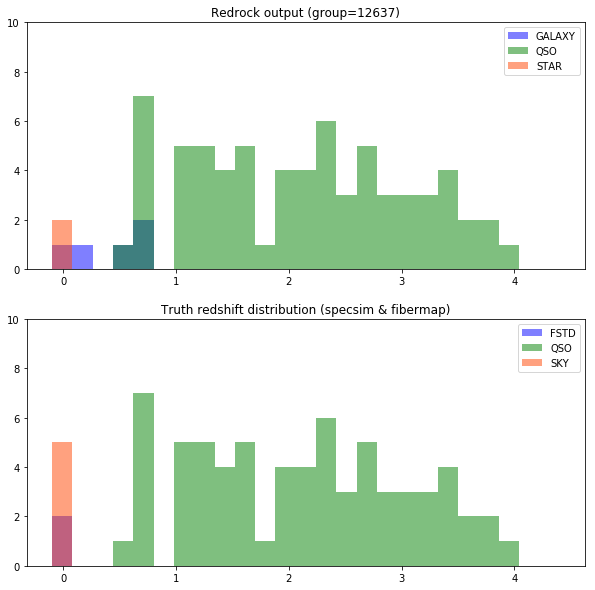

In [6]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

print('zbest results from Redrock on {}'.format(zbestfile))
for spectype in sorted(set(zbest['SPECTYPE'])):
    if spectype=='STAR':
        color='orangered'
    if spectype=='GALAXY':
        color='b'
    if spectype=='QSO':
        color='g'
    jj = (zbest['SPECTYPE'] == spectype)
   # print(spectype,':',sum(hist(zbest['Z'][jj], 25, (-0.1,4.4))[0]))
    nhist=ax[0].hist(zbest['Z'][jj], 25, (-0.1,4.4),color=color,label=format(spectype),alpha=0.5)[0]
    print(spectype,':',sum(nhist))


    ax[0].legend(loc='upper right')
    ax[0].set_ylim(0,10)
ax[0].set_title('Redrock output (group=12637)')

print('Ztruth the {} file'.format(simspecfile))

allobjtype = meta['OBJTYPE']
for objtype in sorted(set(allobjtype)):
    if objtype=='FSTD':
        color='b'
    if objtype=='SKY':
        color='orangered'
    if objtype=='QSO':
        color='green'
    ii = (ztruth['OBJTYPE'] == objtype)
    
    nhist=ax[1].hist(ztruth['REDSHIFT'][ii],25,(-0.1,4.4),color=color,label=format(objtype),alpha=0.5)[0]
    ax[1].legend(loc='upper right')
    ax[1].set_ylim(0,10)
    print(objtype,':',sum(nhist))
ax[1].set_title('Truth redshift distribution (specsim & fibermap)')
fig.subplots_adjust(hspace=0.2)



    



We can see that for the spectra-64-12637 group, the number of QSO's were correctly identified and at first glance there is a good estimate of the redshift.
I also did  this for a sample of 1000 QSO's only, although some STARS and FSTD are also generated by default,  and the result is the same: All QSO's and redshift distribution was recovered. 
Possible the spectra I'm generating is not noisy to make redrock fail for QSO... I'll change exptime and other parameters in the new_exposure function and see if we can generate a different result, and I'll add the use of the function desisim.lya_spectra  to generate QSO spectrum including Lyman-alpha absorption... 